In [6]:
%%capture
! pip install timm tqdm einops

In [2]:
%%capture
! git clone https://github.com/hila-chefer/Transformer-Explainability.git Transformer_Explainability

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
from math import ceil
from time import time
from skimage import color
from tqdm.auto import tqdm
import multiprocessing as mp
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import timm
import torch
import torchvision
import torchsummary
from torch import nn
from torch.optim import Adam
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
#from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

In [4]:
os.chdir(f'./Transformer_Explainability')

In [7]:
from baselines.ViT.ViT_explanation_generator import LRP
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP

In [8]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [9]:
valid_img_path = '/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Viz_Test_Images/00.png'
valid_mask_path = '/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Viz_Test_Images/00_1.png'

In [10]:
valid_img = cv2.resize(cv2.imread(valid_img_path), (224, 224))
valid_mask = cv2.cvtColor(cv2.resize(cv2.imread(valid_mask_path), (224, 224)), cv2.COLOR_BGR2RGB)

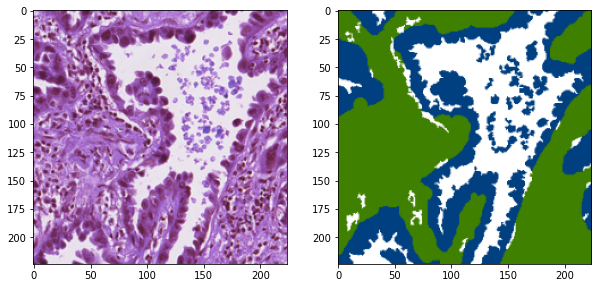

In [11]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 2, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 2, 2)
plt.imshow(valid_mask)

# Pre-processing image

In [12]:
def preprocess_image(img: np.ndarray, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], resized = (224, 224)) -> torch.Tensor:
  
  preprocessing = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Resize((224, 224)),
                                      transforms.Normalize(mean, std),
                                      ])
  return preprocessing(img.copy()).unsqueeze(0)

In [13]:
def reshape_transform(tensor, height=7, width=7):
  result = tensor[:, 1 :  , :].reshape(tensor.size(0),
                                       height, width, tensor.size(2))
  
  # Bring the channels to the first dimension,
  # like in CNNs.
  result = result.transpose(2, 3).transpose(1, 2)
  return result

In [14]:
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    mask = cv2.resize(mask, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [15]:
valid_img_tensor = preprocess_image(valid_img).to(device)

# Transformer Explainibility

In [16]:
#@title WSSS4LUAD class indices to names

CLS2IDX = {0: 'tumor',
           1: 'stroma',
           2: 'normal',}

In [17]:
# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def print_top_classes(predictions, **kwargs):    
    # Print 3 predictions
    prob = torch.sigmoid(predictions)
    class_indices = predictions.data.topk(3, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print('3 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

In [19]:
model = vit_LRP(pretrained=False, num_classes = 3).to(device)

In [20]:
model.load_state_dict(torch.load('../models/cutmix_hila_vit_base_patch16_224_01.pth', map_location=device))
model.eval()
attribution_generator = LRP(model)

In [21]:
output = model(valid_img_tensor.to(device))
print_top_classes(output)

3 classes:
	0 : tumor 		value = 2.654	 prob = 93.4%
	1 : stroma		value = 2.576	 prob = 92.9%
	2 : normal		value = -5.522	 prob = 0.4%


In [23]:
tumor = generate_visualization(valid_img_tensor.squeeze(0), class_index=0)
stroma = generate_visualization(valid_img_tensor.squeeze(0), class_index=1)
normal = generate_visualization(valid_img_tensor.squeeze(0), class_index=2)

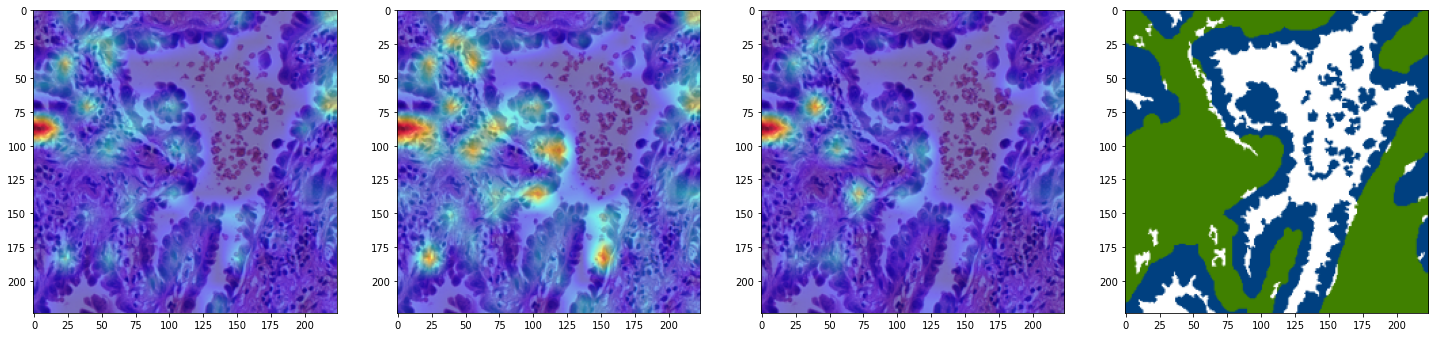

In [25]:
fig = plt.figure(figsize=(25, 30))

ax = fig.add_subplot(1, 4, 1)
plt.imshow(tumor)

ax = fig.add_subplot(1, 4, 2)
plt.imshow(stroma)

ax = fig.add_subplot(1, 4, 3)
plt.imshow(normal)

ax = fig.add_subplot(1, 4, 4)
plt.imshow(valid_mask)

In [34]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/hila_vit_base_patch16_224_01.pth', map_location=device))
model.eval()
attribution_generator = LRP(model)

In [35]:
output = model(valid_img_tensor.to(device))
print_top_classes(output)

3 classes:
	0 : tumor 		value = 8.998	 prob = 100.0%
	2 : normal		value = -3.379	 prob = 3.3%
	1 : stroma		value = -5.399	 prob = 0.5%


In [36]:
tumor = generate_visualization(valid_img_tensor.squeeze(0), class_index=0)
stroma = generate_visualization(valid_img_tensor.squeeze(0), class_index=1)
normal = generate_visualization(valid_img_tensor.squeeze(0), class_index=2)

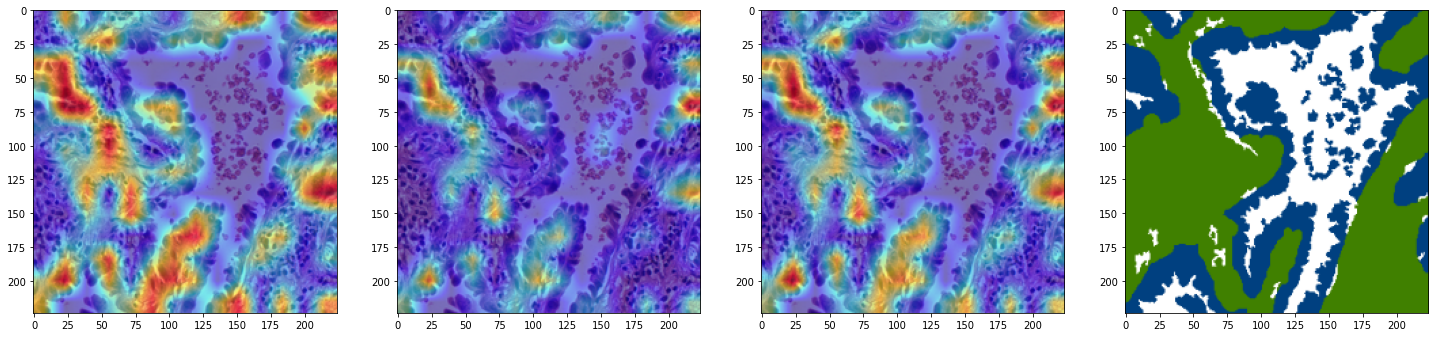

In [37]:
fig = plt.figure(figsize=(25, 30))

ax = fig.add_subplot(1, 4, 1)
plt.imshow(tumor)

ax = fig.add_subplot(1, 4, 2)
plt.imshow(stroma)

ax = fig.add_subplot(1, 4, 3)
plt.imshow(normal)

ax = fig.add_subplot(1, 4, 4)
plt.imshow(valid_mask)